# Train a $\pi^{+}$ vs. $e^{+}$ model using a deep neural network and a BDT

This notebook was developed and tested with Keras version 2.0.6. If you are using an older version, you might encounter problems with imports

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.6'

In [2]:
! nvidia-smi

Sat Aug 12 18:11:48 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.48                 Driver Version: 367.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro K420         On   | 0000:01:00.0     Off |                  N/A |
| 26%   52C    P8    N/A /  N/A |      2MiB /   979MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    On   | 0000:02:00.0     Off |                  N/A |
| 23%   41C    P8    18W / 250W |   2492MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
from functools import partial
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import (Dense, Reshape, Conv2D, LeakyReLU, BatchNormalization,
                          LocallyConnected2D, Activation, ZeroPadding2D,
                          Dropout, Lambda, Flatten, Input, add)

from keras.layers.merge import concatenate, multiply
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, classification_report

In [5]:
from calodata.features import extract_features

In [6]:
# shortcut function 'concat' will represent np.concatenate across the 0th axis
concat = partial(np.concatenate, axis=0)

In [7]:
def load_calodata(fpaths):
    '''
    Returns:
    --------
        data: a list of 3 numpy arrays, representing the energy deposition in each layer
            for a group of showers contained in the file 'fpath'
    '''
    for fpath in fpaths:
        with h5py.File(fpath, 'r') as h5:
            try:
                data = [concat((data[i], h5['layer_{}'.format(i)][:])) for i in xrange(3)]
            except NameError:
                data = [h5['layer_{}'.format(i)][:] for i in xrange(3)]
    return data

Choose which binary classification task to focus on

In [8]:
# CLASS_ONE = 'gamma'
# CLASS_TWO = 'eplus'

CLASS_ONE = 'piplus'
CLASS_TWO = 'eplus'

In [9]:
import glob
print 'Extraing data for ' + CLASS_ONE
c1 = load_calodata(glob.glob(('../data/classification/{}_extra.hdf5').format(CLASS_ONE)))
print 'Extraing data for ' + CLASS_TWO
c2 = load_calodata(glob.glob(('../data/classification/{}_extra.hdf5').format(CLASS_TWO)))
data = map(concat, zip(c1, c2))

labels = np.array([1] * c1[0].shape[0] + [0] * c2[0].shape[0])

Extraing data for piplus
Extraing data for eplus


In [10]:
# import glob
# print 'Extraing data for ' + CLASS_ONE
# c1_old = load_calodata(glob.glob(('../data/classification/{}.hdf5').format(CLASS_ONE)))
# print 'Extraing data for ' + CLASS_TWO
# c2_old = load_calodata(glob.glob(('../data/classification/{}.hdf5').format(CLASS_TWO)))
# data_old = map(concat, zip(c1_old, c2_old))

# labels_old = np.array([1] * c1_old[0].shape[0] + [0] * c2_old[0].shape[0])

In [11]:
print 'Number of {} events = {}'.format(CLASS_ONE, c1[0].shape[0])
print 'Number of {} events = {}'.format(CLASS_TWO, c2[0].shape[0])

Number of piplus events = 500000
Number of eplus events = 500000


Use a pre-written module to calculate the shower shape variables for the showers in our dataset and save them in an object called 'features'

In [12]:
features = extract_features(data) # shower shapes

In [13]:
# features_old = extract_features(data_old) # shower shapes

In [14]:
features.shape

(1000000, 20)

In [15]:
# for f, fold in zip(features.T, features_old.T):
#     plt.figure(figsize=(10,10))
#     bins = np.linspace(f.min(), f.max(), 20)
#     _ = plt.hist(f[labels==0], bins=bins, label='f 0', normed=True, histtype='step')
#     _ = plt.hist(f[labels==1], bins=bins, label='f 1', normed=True, histtype='step')
#     _ = plt.hist(fold[labels_old==0], bins=bins, label='old 0', normed=True, histtype='step')
#     _ = plt.hist(fold[labels_old==1], bins=bins, label='old 1', normed=True, histtype='step')
#     plt.legend()
#     plt.show()

For no good reason, we are shuffling and splitting into train and test set by hand. 

TO-DO: use sklearn train_test_split

TO-DO: save out a final validation set as well

In [16]:
# random shuffle
np.random.seed(0)
ix = np.array(range(len(labels)))
np.random.shuffle(ix)

# number of examples to train on
nb_train = int(0.7 * len(ix))

# train test split
ix_train = ix[:nb_train]
ix_test = ix[nb_train:]

features_train = features[ix_train]
data_train = [np.expand_dims(d[ix_train], -1) / 1000. for d in data]
labels_train = labels[ix_train]

features_test = features[ix_test]
data_test = [np.expand_dims(d[ix_test], -1) / 1000. for d in data]
labels_test = labels[ix_test]

In [17]:
raveled_train = np.concatenate([d.reshape(d.shape[0], -1) for d in data_train], axis=-1)
raveled_test = np.concatenate([d.reshape(d.shape[0], -1) for d in data_test], axis=-1)

# LAGAN-style discriminator

In [22]:
def build_model(image, selu=True, bn=True):
    '''
    Build LAGAN-style discriminator
    '''
    x = Conv2D(64, (2, 2), padding='same')(image)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D((1, 1))(image)
    x = LocallyConnected2D(8 * 4, (3, 3), padding='valid', strides=(1, 2))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(16 * 4, (2, 2), padding='valid')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(32 * 4, (2, 2), padding='valid', strides=(1, 2))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    return x

In [23]:
shapes = [d.shape[1:] for d in data_train]

x = [Input(shape=sh) for sh in shapes]

h = concatenate(map(partial(build_model), x)) 

h = Dense(256)(h)
h = Activation('relu')(h)
h = Dropout(0.5)(h)

y = Dense(1, activation='sigmoid')(h)

image_dnn = Model(x, y)
image_dnn.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [24]:
image_dnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 96, 1)      0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 12, 12, 1)     0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 12, 6, 1)      0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 5, 98, 1)      0           input_2[0][0]                    
___________________________________________________________________________________________

In [25]:
callbacks = [
    EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
    ModelCheckpoint('LAGAN{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [24]:
try:
    image_dnn.fit(data_train, labels_train, callbacks=callbacks, verbose=True,
                  validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 300s - loss: 0.0262 - acc: 0.9934 - val_loss: 0.0135 - val_acc: 0.9961
Epoch 2/100
489999/489999 [==============================] - 288s - loss: 0.0166 - acc: 0.9958 - val_loss: 0.0100 - val_acc: 0.9971
Epoch 3/100
489999/489999 [==============================] - 287s - loss: 0.0152 - acc: 0.9963 - val_loss: 0.0140 - val_acc: 0.9966
Epoch 4/100
489999/489999 [==============================] - 288s - loss: 0.0134 - acc: 0.9966 - val_loss: 0.0080 - val_acc: 0.9976
Epoch 5/100
489999/489999 [==============================] - 288s - loss: 0.0127 - acc: 0.9968 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 6/100
489999/489999 [==============================] - 288s - loss: 0.0120 - acc: 0.9972 - val_loss: 0.0119 - val_acc: 0.9959
Epoch 7/100
489999/489999 [==============================] - 288s - loss: 0.0112 - acc: 0.9973 - val_loss: 0.0071 - val_acc: 0.9980
Epoch 8/100
489999/48999

In [24]:
image_dnn.load_weights('LAGAN{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
image_dnn.save_weights('LAGAN{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [27]:
image_dnn.load_weights('LAGAN{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [ ]:
# with h5py.File('LAGAN{}vs{}-split-indices.h5'.format(CLASS_ONE, CLASS_TWO), 'w') as h5:
#     h5['train'] = ix_train
#     h5['test'] = ix_test

In [25]:
yhat_image_dnn = image_dnn.predict(data_test, verbose=True).ravel()

300000/300000 [==============================] - 216s   


# Train a DNN on shower shapes

In [26]:
def build_feature_dnn(x):

    h = Dense(256)(x)
    h = Dropout(0.2)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(256)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(256)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)
    
    h = Dense(256)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(32)(h)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = Dense(1)(h)
    y = Activation('sigmoid')(h)
    

    return y

In [27]:
x = Input(shape=(features_train.shape[1], ))
feature_dnn = Model(x, build_feature_dnn(x))
feature_dnn.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [78]:
feature_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5376      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

In [17]:
callbacks = [
    EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
    ModelCheckpoint('SS{}vs{}-features-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [18]:
try:
    feature_dnn.fit(features_train / features_train.max(axis=0)[np.newaxis, :], labels_train, callbacks=callbacks, verbose=True,
                  validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 72s - loss: 0.0212 - acc: 0.9938 - val_loss: 0.0095 - val_acc: 0.9973
Epoch 2/100
489999/489999 [==============================] - 64s - loss: 0.0140 - acc: 0.9962 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 3/100
489999/489999 [==============================] - 64s - loss: 0.0125 - acc: 0.9967 - val_loss: 0.0133 - val_acc: 0.9971
Epoch 4/100
489999/489999 [==============================] - 65s - loss: 0.0115 - acc: 0.9970 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 5/100
489999/489999 [==============================] - 65s - loss: 0.0108 - acc: 0.9970 - val_loss: 0.0089 - val_acc: 0.9976
Epoch 6/100
489999/489999 [==============================] - 64s - loss: 0.0104 - acc: 0.9972 - val_loss: 0.0080 - val_acc: 0.9977
Epoch 7/100
489999/489999 [==============================] - 64s - loss: 0.0103 - acc: 0.9973 - val_loss: 0.0072 - val_acc: 0.9979
Epoch 8/100
489999/489999 [====

In [28]:
feature_dnn.load_weights('SS{}vs{}-features-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
feature_dnn.save_weights('SS{}vs{}-features-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [20]:
feature_dnn.load_weights('SS{}vs{}-features-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [29]:
yhat_feature_dnn = feature_dnn.predict(features_test / features_test.max(axis=0)[np.newaxis, :], verbose=True).ravel()

299968/300000 [============================>.] - ETA: 0s

# Train a BDT on shower shapes

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
base_clf = GradientBoostingClassifier(verbose=2)
parameters = {
    'n_estimators':[100, 200, 300],
    'max_depth':[3, 5]
}

In [ ]:
clf.best_params_

In [ ]:
clf = GridSearchCV(base_clf, parameters, n_jobs=7)

In [ ]:
clf.fit(features_train, labels_train)

In [ ]:
yhat_feature_bdt = clf.predict_proba(features_test)[:, 1].ravel()


# Train simple DNN on pix

In [30]:
def build_simple_dnn(x):

    h = Dense(512)(x)
    h = Dropout(0.2)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(2048)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)
    
    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(128)(h)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = Dense(1)(h)
    y = Activation('sigmoid')(h)
    

    return y

In [31]:
x = Input(shape=(raveled_train.shape[1], ))
raveled_dnn = Model(x, build_simple_dnn(x))
raveled_dnn.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [37]:
raveled_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 504)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               258560    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1024)              0         
__________

In [38]:
callbacks = [
    EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
    ModelCheckpoint('PixVec{}vs{}-raveled-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [39]:
try:
    raveled_dnn.fit(raveled_train, labels_train, callbacks=callbacks, verbose=True,
                          validation_split=0.3, batch_size=128, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 69s - loss: 0.0237 - acc: 0.9932 - val_loss: 0.0114 - val_acc: 0.9967
Epoch 2/100
489999/489999 [==============================] - 68s - loss: 0.0139 - acc: 0.9961 - val_loss: 0.0120 - val_acc: 0.9965
Epoch 3/100
489999/489999 [==============================] - 68s - loss: 0.0121 - acc: 0.9966 - val_loss: 0.0099 - val_acc: 0.9971
Epoch 4/100
489999/489999 [==============================] - 69s - loss: 0.0109 - acc: 0.9969 - val_loss: 0.0077 - val_acc: 0.9977
Epoch 5/100
489999/489999 [==============================] - 68s - loss: 0.0106 - acc: 0.9972 - val_loss: 0.0071 - val_acc: 0.9980
Epoch 6/100
489999/489999 [==============================] - 69s - loss: 0.0102 - acc: 0.9972 - val_loss: 0.0092 - val_acc: 0.9975
Epoch 7/100
489999/489999 [==============================] - 68s - loss: 0.0099 - acc: 0.9973 - val_loss: 0.0068 - val_acc: 0.9979
Epoch 8/100
489999/489999 [====

In [32]:
raveled_dnn.load_weights('PixVec{}vs{}-raveled-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
raveled_dnn.save_weights('PixVec{}vs{}-raveled-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [42]:
raveled_dnn.load_weights('PixVec{}vs{}-raveled-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [33]:
yhat_raveled_dnn = raveled_dnn.predict(raveled_test, verbose=True).ravel()

299936/300000 [============================>.] - ETA: 0s

# Train DenseNet

In [30]:
% cd ~/keras-contrib/keras_contrib/applications/
% run densenet.py
#from densenet import DenseNet as build_densenet
% cd /home/mpaganini/CaloGAN/classification/

/home/mpaganini/keras-contrib/keras_contrib/applications
/home/mpaganini/CaloGAN/classification


In [31]:
build_densenet = DenseNet

In [19]:
# to support 1 channel images, just comment out the input_shape = _obtain_input_shape part
# just set the input_shape when you build the model (risky without checks)

In [18]:
dnet1 = build_densenet(weights=None, classes=1, activation='sigmoid',
                       input_shape=(12, 12, 1), nb_dense_block=1,
                      include_top=True)

densenet.py:507: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., activation="sigmoid", bias_regularizer=<keras.reg...)`


In [20]:
dnet1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 12, 12, 1)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 12, 12, 16)    144         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 12, 12, 16)    64          initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 12, 12, 16)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [21]:
#from keras.utils.vis_utils import plot_model

In [22]:
#plot_model(dnet, to_file='dnet.png', show_shapes=True)

In [23]:
#from IPython.display import Image
#Image(filename='dnet.png') 

In [19]:
dnet1.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [25]:
callbacks = [
    EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
    ModelCheckpoint('DenseNet1{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True),
]

In [30]:
# Train a Dense Net only on the middle layer
try:
    dnet1.fit(data_train[1], labels_train, callbacks=callbacks, verbose=True,
                  validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 127s - loss: 0.0304 - acc: 0.9937 - val_loss: 0.0840 - val_acc: 0.9794
Epoch 2/100
489999/489999 [==============================] - 125s - loss: 0.0300 - acc: 0.9938 - val_loss: 0.1758 - val_acc: 0.9652
Epoch 3/100
489999/489999 [==============================] - 126s - loss: 0.0294 - acc: 0.9939 - val_loss: 1.3075 - val_acc: 0.7699
Epoch 4/100
489999/489999 [==============================] - 126s - loss: 0.0288 - acc: 0.9940 - val_loss: 0.0530 - val_acc: 0.9866
Epoch 5/100
489999/489999 [==============================] - 125s - loss: 0.0288 - acc: 0.9939 - val_loss: 1.3921 - val_acc: 0.7879
Epoch 6/100
489999/489999 [==============================] - 125s - loss: 0.0286 - acc: 0.9939 - val_loss: 0.1766 - val_acc: 0.9405
Epoch 7/100
489999/489999 [==============================] - 125s - loss: 0.0282 - acc: 0.9939 - val_loss: 0.0465 - val_acc: 0.9862
Epoch 8/100
489999/48999

489999/489999 [==============================] - 126s - loss: 0.0259 - acc: 0.9942 - val_loss: 1.5563 - val_acc: 0.5760
Epoch 64/100
489999/489999 [==============================] - 126s - loss: 0.0249 - acc: 0.9945 - val_loss: 0.9741 - val_acc: 0.7414
Epoch 65/100
489999/489999 [==============================] - 126s - loss: 0.0252 - acc: 0.9944 - val_loss: 0.0468 - val_acc: 0.9873
Epoch 66/100
489999/489999 [==============================] - 126s - loss: 0.0248 - acc: 0.9944 - val_loss: 1.6008 - val_acc: 0.6975
Epoch 67/100
489999/489999 [==============================] - 126s - loss: 0.0251 - acc: 0.9944 - val_loss: 2.1769 - val_acc: 0.6182
Epoch 68/100
489999/489999 [==============================] - 126s - loss: 0.0247 - acc: 0.9945 - val_loss: 0.0353 - val_acc: 0.9914
Epoch 69/100
489999/489999 [==============================] - 126s - loss: 0.0248 - acc: 0.9945 - val_loss: 0.0630 - val_acc: 0.9853
Epoch 70/100
489999/489999 [==============================] - 126s - loss: 0.0248 

In [20]:
dnet1.load_weights('DenseNet1{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
dnet1.save_weights('DenseNet1{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [22]:
dnet1.load_weights('DenseNet1{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [21]:
yhat_dnet = dnet1.predict(data_test[1], verbose=True).ravel()

299872/300000 [============================>.] - ETA: 0s

In [29]:
build_densenet?

In [32]:
dnet0 = build_densenet(weights=None, classes=1, activation='sigmoid',
                       input_shape=(3, 96, 1),
                       nb_dense_block=1, bottleneck=False) 
# ugly shapes, but ok

<string>:508: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., activation="sigmoid", bias_regularizer=<keras.reg...)`


In [33]:
dnet0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 96, 1)      0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 3, 96, 16)     144         input_2[0][0]                    
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 3, 96, 16)     0           initial_conv2D[0][0]             
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 3, 96, 12)     1728        activation_2[0][0]               
___________________________________________________________________________________________

In [34]:
dnet0.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [38]:
# Train a Dense Net only on the first layer
try:
    dnet0.fit(data_train[0], labels_train, 
              callbacks=[
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('DenseNet0{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=True, validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 103s - loss: 0.1055 - acc: 0.9781 - val_loss: 0.0747 - val_acc: 0.9896
Epoch 2/100
489999/489999 [==============================] - 105s - loss: 0.0637 - acc: 0.9894 - val_loss: 0.0596 - val_acc: 0.9907
Epoch 3/100
489999/489999 [==============================] - 105s - loss: 0.0558 - acc: 0.9911 - val_loss: 0.0516 - val_acc: 0.9924
Epoch 4/100
489999/489999 [==============================] - 105s - loss: 0.0505 - acc: 0.9921 - val_loss: 0.0492 - val_acc: 0.9928
Epoch 5/100
489999/489999 [==============================] - 105s - loss: 0.0480 - acc: 0.9926 - val_loss: 0.0467 - val_acc: 0.9928
Epoch 6/100
489999/489999 [==============================] - 105s - loss: 0.0459 - acc: 0.9929 - val_loss: 0.0661 - val_acc: 0.9885
Epoch 7/100
489999/489999 [==============================] - 105s - loss: 0.0439 - acc: 0.9930 - val_loss: 0.0799 - val_acc: 0.9856
Epoch 8/100
489999/48999

In [39]:
dnet0.load_weights('DenseNet0{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
dnet0.save_weights('DenseNet0{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))
dnet0.load_weights('DenseNet0{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [40]:
yhat_dnet0 = dnet0.predict(data_test[0], verbose=True).ravel()

299552/300000 [============================>.] - ETA: 0s

In [45]:
dnet2 = build_densenet(weights=None, classes=1, activation='sigmoid',
                       input_shape=(12, 6, 1), nb_dense_block=1, bottleneck=False)
# it doesn't work with nb_dense_block=3

In [46]:
dnet2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 12, 6, 1)      0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 12, 6, 16)     144         input_6[0][0]                    
____________________________________________________________________________________________________
activation_15 (Activation)       (None, 12, 6, 16)     0           initial_conv2D[0][0]             
____________________________________________________________________________________________________
conv2d_13 (Conv2D)               (None, 12, 6, 12)     1728        activation_15[0][0]              
___________________________________________________________________________________________

In [49]:
dnet2.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [50]:
# Train a Dense Net only on the last layer
try:
    dnet2.fit(data_train[2], labels_train, 
              callbacks=[
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('DenseNet2{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=True, validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 41s - loss: 0.2031 - acc: 0.9456 - val_loss: 0.1574 - val_acc: 0.9632
Epoch 2/100
489999/489999 [==============================] - 41s - loss: 0.1602 - acc: 0.9617 - val_loss: 0.1447 - val_acc: 0.9664
Epoch 3/100
489999/489999 [==============================] - 41s - loss: 0.1494 - acc: 0.9638 - val_loss: 0.1355 - val_acc: 0.9672
Epoch 4/100
489999/489999 [==============================] - 41s - loss: 0.1418 - acc: 0.9655 - val_loss: 0.1396 - val_acc: 0.9659
Epoch 5/100
489999/489999 [==============================] - 41s - loss: 0.1365 - acc: 0.9661 - val_loss: 0.1362 - val_acc: 0.9629
Epoch 6/100
489999/489999 [==============================] - 41s - loss: 0.1349 - acc: 0.9663 - val_loss: 0.1271 - val_acc: 0.9678
Epoch 7/100
489999/489999 [==============================] - 41s - loss: 0.1329 - acc: 0.9664 - val_loss: 0.1329 - val_acc: 0.9675
Epoch 8/100
489999/489999 [====

489999/489999 [==============================] - 41s - loss: 0.1073 - acc: 0.9726 - val_loss: 0.1173 - val_acc: 0.9672
Epoch 30/100
489999/489999 [==============================] - 41s - loss: 0.1067 - acc: 0.9727 - val_loss: 0.1265 - val_acc: 0.9655
Epoch 31/100
489999/489999 [==============================] - 41s - loss: 0.1071 - acc: 0.9726 - val_loss: 0.1445 - val_acc: 0.9627
Epoch 32/100
489999/489999 [==============================] - 41s - loss: 0.1058 - acc: 0.9729 - val_loss: 0.1066 - val_acc: 0.9730
Epoch 33/100
489999/489999 [==============================] - 41s - loss: 0.1059 - acc: 0.9729 - val_loss: 0.1095 - val_acc: 0.9722
Epoch 34/100
489999/489999 [==============================] - 42s - loss: 0.1057 - acc: 0.9731 - val_loss: 0.1015 - val_acc: 0.9731
Epoch 35/100
489999/489999 [==============================] - 42s - loss: 0.1053 - acc: 0.9731 - val_loss: 0.1044 - val_acc: 0.9725
Epoch 36/100
489999/489999 [==============================] - 41s - loss: 0.1047 - acc: 0

In [51]:
dnet2.load_weights('DenseNet2{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
dnet2.save_weights('DenseNet2{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))
dnet2.load_weights('DenseNet2{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [52]:
yhat_dnet2 = dnet2.predict(data_test[2], verbose=True).ravel()

299744/300000 [============================>.] - ETA: 0s

# Merge DenseNets into one

In [44]:
shapes = [d.shape[1:] for d in data_train]

x = [Input(shape=sh) for sh in shapes]

In [56]:
dnet_layer0 = build_densenet(weights=None, input_shape=(3, 96, 1), nb_dense_block=1,
                      include_top=False)
dnet_layer1 = build_densenet(weights=None, input_shape=(12, 12, 1), nb_dense_block=1,
                      include_top=False)
dnet_layer2 = build_densenet(weights=None, input_shape=(12, 6, 1), nb_dense_block=1,
                      include_top=False)
dnet_merged = [dnet_layer0, dnet_layer1, dnet_layer2]

In [57]:
features = [f(xi) for f, xi in zip(dnet_merged, x)]

In [58]:
from keras.layers.merge import Concatenate

In [59]:
y = Dense(1, activation='sigmoid')(Concatenate()(features))

In [60]:
image_dnet_merged = Model(x, y)

In [61]:
image_dnet_merged.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 96, 1)      0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 12, 12, 1)     0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 12, 6, 1)      0                                            
____________________________________________________________________________________________________
model_3 (Model)                  (None, 160)           107056      input_3[0][0]                    
___________________________________________________________________________________________

In [62]:
image_dnet_merged.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [63]:
# Train a merged Dense Net
try:
    image_dnet_merged.fit(data_train, labels_train, 
              callbacks=[
                  EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                  ModelCheckpoint('DenseNet_noBN_merged_{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO),
                    monitor='val_loss', verbose=True, save_best_only=True)
              ],
              verbose=True, validation_split=0.3, batch_size=256, epochs=100)
except KeyboardInterrupt:
    print 'ending early'

Train on 489999 samples, validate on 210001 samples
Epoch 1/100
489999/489999 [==============================] - 189s - loss: 0.0991 - acc: 0.9890 - val_loss: 0.0558 - val_acc: 0.9958
Epoch 2/100
489999/489999 [==============================] - 189s - loss: 0.0441 - acc: 0.9959 - val_loss: 0.0482 - val_acc: 0.9951
Epoch 3/100
489999/489999 [==============================] - 189s - loss: 0.0339 - acc: 0.9967 - val_loss: 0.0288 - val_acc: 0.9969
Epoch 4/100
489999/489999 [==============================] - 189s - loss: 0.0291 - acc: 0.9969 - val_loss: 0.0479 - val_acc: 0.9936
Epoch 5/100
489999/489999 [==============================] - 189s - loss: 0.0313 - acc: 0.9964 - val_loss: 0.0399 - val_acc: 0.9950
Epoch 6/100
489999/489999 [==============================] - 189s - loss: 0.0271 - acc: 0.9970 - val_loss: 0.0407 - val_acc: 0.9939
Epoch 7/100
489999/489999 [==============================] - 189s - loss: 0.0250 - acc: 0.9971 - val_loss: 0.0223 - val_acc: 0.9977
Epoch 8/100
489999/48999

In [64]:
image_dnet_merged.load_weights('DenseNet_noBN_merged_{}vs{}-chkpt.h5'.format(CLASS_ONE, CLASS_TWO))
image_dnet_merged.save_weights('DenseNet_noBN_merged_{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))
image_dnet_merged.load_weights('DenseNet_noBN_merged_{}vs{}-final.h5'.format(CLASS_ONE, CLASS_TWO))

In [65]:
yhat_dnet_merged = image_dnet_merged.predict(data_test, verbose=True).ravel()

300000/300000 [==============================] - 70s    


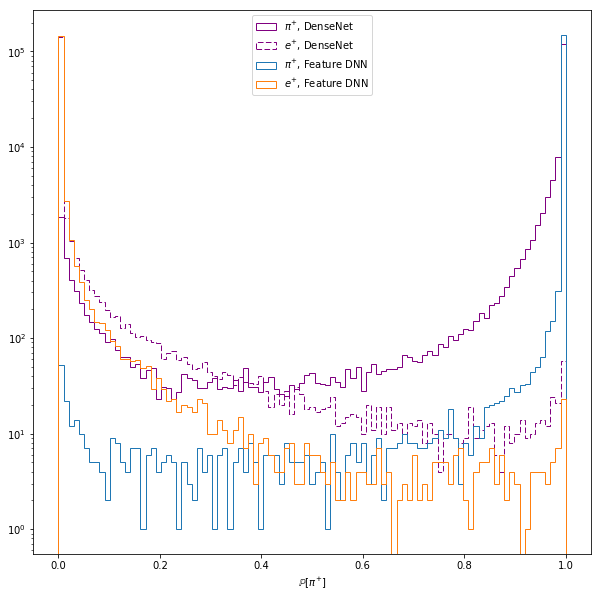

In [92]:
plt.figure(figsize=(10, 10))
bins = np.linspace(0, 1, 100)
# plt.hist(yhat_image_dnn[labels_test == 1], histtype='step', bins=bins, label=r'$\pi^{+}$, Image DNN', color='red')
# plt.hist(yhat_image_dnn[labels_test == 0], histtype='step', bins=bins, label=r'$e^{+}$, Image DNN', color='red',
#         linestyle='dashed')
plt.hist(yhat_dnet_merged[labels_test == 1], histtype='step', bins=bins, label=r'$\pi^{+}$, DenseNet', color='purple')
plt.hist(yhat_dnet_merged[labels_test == 0], histtype='step', bins=bins, label=r'$e^{+}$, DenseNet', color='purple',
        linestyle='dashed')
plt.hist(yhat_feature_dnn[labels_test == 1], histtype='step', bins=bins, label=r'$\pi^{+}$, Feature DNN')
plt.hist(yhat_feature_dnn[labels_test == 0], histtype='step', bins=bins, label=r'$e^{+}$, Feature DNN')
plt.legend(loc='upper center')
plt.yscale('log')
# plt.xlim((0.99999, 1))
# plt.xscale('log')
plt.xlabel(r'$\mathbb{P}[\pi^{+}]$')

In [66]:
# fpr_image_dnn, tpr_image_dnn, _ = roc_curve(labels_test, abs(1-yhat_image_dnn), pos_label=0)
# fpr_dnet, tpr_dnet, _ = roc_curve(labels_test, abs(1-yhat_dnet), pos_label=0)
fpr_dnet0, tpr_dnet0, _ = roc_curve(labels_test, abs(1-yhat_dnet0), pos_label=0)
fpr_dnet2, tpr_dnet2, _ = roc_curve(labels_test, abs(1-yhat_dnet2), pos_label=0)
# fpr_dnet_mean, tpr_dnet_mean, _ = roc_curve(labels_test,
#                                             abs(1 - ((yhat_dnet2 + yhat_dnet + yhat_dnet0)/3) ),
#                                             pos_label=0)

fpr_dnet_merged, tpr_dnet_merged, _ = roc_curve(labels_test, abs(1-yhat_dnet_merged), pos_label=0)
# fpr_raveled_dnn, tpr_raveled_dnn, _ = roc_curve(labels_test, abs(1-yhat_raveled_dnn), pos_label=0)
# fpr_feature_dnn, tpr_feature_dnn, _ = roc_curve(labels_test, abs(1-yhat_feature_dnn), pos_label=0)
# fpr_feature_bdt, tpr_feature_bdt, _ = roc_curve(labels_test, yhat_feature_bdt)

In [49]:
roc_curve?

In [ ]:
with h5py.File('{}-vs-{}-outputs.h5'.format(CLASS_ONE, CLASS_TWO), 'w') as h5:
    h5['y'] = labels_test
    h5['nn_image'] = yhat_image_dnn
    h5['nn_raveled'] = yhat_raveled_dnn
    h5['nn_showershapes'] = yhat_feature_dnn
    h5['bdt_showershapes'] = yhat_feature_bdt

In [ ]:
slices = np.linspace(0, 1, 10000000)

In [ ]:
tpr, _ = np.histogram(yhat[labels_test == 1], bins=slices)
fpr, _ = np.histogram(yhat[labels_test == 0], bins=slices)

In [ ]:
tpr = np.cumsum(tpr[::-1])[::-1]
fpr = np.cumsum(fpr[::-1])[::-1]

/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
/home/mpaganini/venv/keras2tf1/lib

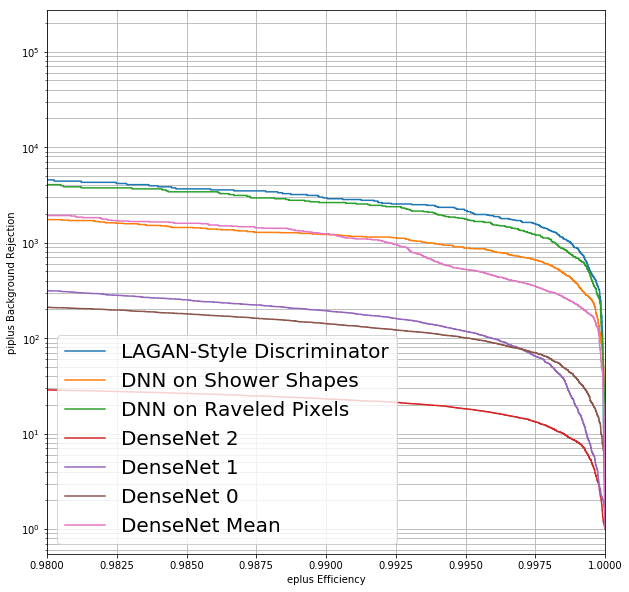

In [70]:
plt.figure(figsize=(10, 10))
plt.plot(tpr_image_dnn, 1 / fpr_image_dnn, label='LAGAN-Style Discriminator')
plt.plot(tpr_feature_dnn, 1 / fpr_feature_dnn, label='DNN on Shower Shapes')
plt.plot(tpr_raveled_dnn, 1 / fpr_raveled_dnn, label='DNN on Raveled Pixels')

plt.plot(tpr_dnet2, 1 / fpr_dnet2, label='DenseNet 2')
plt.plot(tpr_dnet, 1 / fpr_dnet, label='DenseNet 1')
plt.plot(tpr_dnet0, 1 / fpr_dnet0, label='DenseNet 0')
plt.plot(tpr_dnet_mean, 1 / fpr_dnet_mean, label='DenseNet Mean')
# plt.plot(tpr_dnet_merged, 1 / fpr_dnet_merged, label='DenseNet')


plt.yscale('log')
plt.grid('on', 'both')
plt.xlim((0.98, 1))
plt.xlabel('{} Efficiency'.format(CLASS_TWO))
plt.ylabel('{} Background Rejection'.format(CLASS_ONE))
plt.legend(fontsize=20, loc='lower left')

/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mpaganini/venv/keras2tf1/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


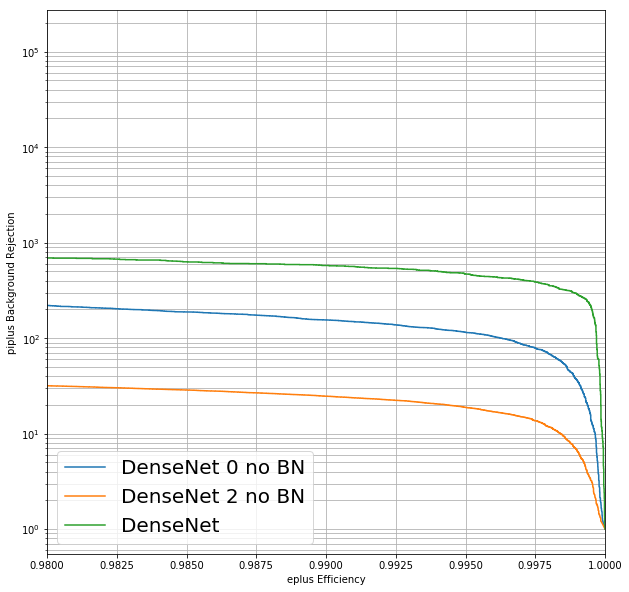

In [67]:
plt.figure(figsize=(10, 10))
plt.plot(tpr_dnet0, 1 / fpr_dnet0, label='DenseNet 0 no BN')
plt.plot(tpr_dnet2, 1 / fpr_dnet2, label='DenseNet 2 no BN')
plt.plot(tpr_dnet_merged, 1 / fpr_dnet_merged, label='DenseNet')

plt.yscale('log')
plt.grid('on', 'both')
plt.xlim((0.98, 1))
plt.xlabel('{} Efficiency'.format(CLASS_TWO))
plt.ylabel('{} Background Rejection'.format(CLASS_ONE))
plt.legend(fontsize=20, loc='lower left')

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(tpr_image_dnn, fpr_image_dnn, label='Deep NN on Calorimeter Hits')
plt.plot(tpr_raveled_dnn, fpr_raveled_dnn, label='FCNN on Calorimeter Hits')
plt.plot(tpr_feature_dnn, fpr_feature_dnn, label='DNN on Shower Shapes')
plt.plot(tpr_feature_bdt, fpr_feature_bdt, label='BDT on Shower Shapes')
# plt.plot(tpr_raveled_dnn, fpr_raveled_dnn, label='Simple DNN on Calorimeter Hits')
plt.yscale('log')
plt.grid('on', 'both')
plt.xlim((0.95, 1))
plt.xlabel('{} Efficiency'.format(CLASS_ONE))
plt.ylabel('{} Background Efficienct'.format(CLASS_TWO))
plt.legend(fontsize=20, loc='upper left')

In [ ]:
from scipy import interpolate
from matplotlib import gridspec


In [ ]:
def uix(a):
    return np.unique(a, return_index=True)[1]

In [ ]:
eff_interp = np.linspace(0.05, 1, 100)
# interp_image_dnn = np.interp(eff_interp, tpr_image_dnn, fpr_image_dnn)
# interp_feature_dnn = np.interp(eff_interp, tpr_feature_dnn, fpr_feature_dnn)
# interp_raveled_dnn = np.interp(eff_interp, tpr_raveled_dnn, fpr_raveled_dnn)

interp_image_dnn = interpolate.interp1d(tpr_image_dnn[uix(tpr_image_dnn)], fpr_image_dnn[uix(tpr_image_dnn)], kind='cubic')(eff_interp)
interp_feature_dnn = interpolate.interp1d(tpr_feature_dnn[uix(tpr_feature_dnn)], fpr_feature_dnn[uix(tpr_feature_dnn)], kind='cubic')(eff_interp)
# interp_raveled_dnn = interpolate.interp1d(tpr_raveled_dnn[uix(tpr_raveled_dnn)], fpr_raveled_dnn[uix(tpr_raveled_dnn)], kind='cubic')(eff_interp)

kern_size = 20
kern = [1 / float(kern_size)] * kern_size
interp_image_dnn = np.convolve(interp_image_dnn, kern, mode='same')
interp_feature_dnn = np.convolve(interp_feature_dnn, kern, mode='same')
# interp_raveled_dnn = np.convolve(interp_raveled_dnn, kern, mode='same')

In [ ]:
plt.figure(figsize=(7, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
ax = plt.subplot(gs[0])
plt.plot(tpr_image_dnn, fpr_image_dnn, label='ResNet on Calorimeter Hits')
plt.plot(tpr_feature_dnn, fpr_feature_dnn, label='DNN on Shower Shapes')
# plt.plot(tpr_raveled_dnn, fpr_raveled_dnn, label='Simple DNN on Calorimeter Hits')
plt.yscale('log')
plt.grid('on', 'both')
plt.xlim((0, 1))
plt.xlabel(r'$\pi^{+}$ efficiency')
plt.ylabel(r'$e^{+}$ efficiency')
plt.legend(loc='upper left')

plt.subplot(gs[1], sharex=ax)
plt.plot(eff_interp, interp_feature_dnn / interp_image_dnn, label='ResNet on Calorimeter Hits')
plt.plot(eff_interp, interp_feature_dnn / interp_feature_dnn, label='DNN on Shower Shapes')
# plt.plot(eff_interp, interp_feature_dnn / interp_raveled_dnn, label='Simple DNN on Calorimeter Hits')
# plt.yscale('log')
plt.grid('on', 'both')
# plt.xlim((0.99, 1))
# plt.xlabel(r'$\pi^{+}$ efficiency')
plt.ylabel(r'Ratio of $e^{+}$ efficiencies of DNN on Shower Shapes to X')
plt.legend(loc='upper left')